Эксперименты с модулем символьных вычислений `sympy` на примере [задачи](https://lisakov.com/blog/air-resistance/) 

# Движение с сопротивлением воздуха
Тело массой $m$ бросили по углом $\alpha$ к горизонту со скоростью $v_0$. Считать, что сила сопротивления воздуха пропорциональна скорости $F_{сопр} = kv$ (коэффициент $k$ известен). Найти законы движения тела.

Как проделать тоже самое, что в оригинальной статье, но вообще без бумаги, только в одном `jupyter` ноутбуке? Могут ли быть такими же наглядными символьные вычисления на питоне? Можно ли сделать более-менее универсальный конвеер на `sympy` для решения таких задач?

**Содержание**<a id='toc0_'></a>    
- [Общее решение](#toc1_)    
- [Задача Коши](#toc2_)    
- [Картинки](#toc3_)    
- [Дальность](#toc4_)    
  - [Без сопротивления воздуха](#toc4_1_)    
  - [С сопротивлением воздуха](#toc4_2_)    
  - [Аналитически - не решается](#toc4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Нужно заметить, что `sympy` вообще никак не умеет выводить на печать несколько объектов (уравнений) в виде единого объекта (например, системы уравнений). Часто для этого применяются некоторые костыли в виде заворачивания уравнений в объект-матрицу, объект-множество и т.п. встроенные объекты. Но в последней версии `sympy` (1.10.1) вместо добавления объекта "система уравнений" или типа того, авторы зачем-то добавили на такое использование матриц навязчивый варнинг о том, что матрицы мол совсем не для этого, и предлагают использовать вместо нее `TableForm`, что даже близко не является заменой. Напишем костыль для вывода систем уравнений в `jupyter` используя объект `Array`, про который пока нет варнингов.

In [1]:
from sympy import *

def P(*expressions, row=False):
    """ Вывод нескольких выражений в строку и столбик. Например, систем уравнений """
    
    def undict(e):
        """ Если объекты являются словарями переменная:выражение, какие выдает по-умолчанию, например, solve"""
        if type(e) == type(dict()):
            return [Eq(k, v) for k, v in e.items()]
        return [e]
        
    return Array(list(expressions)) if row else Array([undict(e) for e in expressions])

## <a id='toc1_'></a>[Общее решение](#toc0_)

Основная система ОДУ (второй закон Ньютона)

$$\vec a = \frac{\vec F}{m}$$

Для двухмерного случая в параметрическом представлении:

$$
\begin{equation*}
 \begin{cases}
   \ddot x(t) = F_x / m
   \\
   \ddot y(t) = F_y /m
 \end{cases}
\end{equation*}
$$

По $x$ действует только сила сопротивления воздуха: $F_x = - k  v  \cos(\alpha)$

По $y$ кроме того действует еще сила тяжести: $F_y = - m  g - k  v  \sin(\alpha)$

Такая модель сопротивления воздуха (среды) называется закон сопротивления Стокса, если зависимость квадратичная - это закон сопротивления Ньютона. Переход между этими моделями поведения определяется числом Рейнольдса, которое зависит от скорости, размера объекта и кинематической вязкости среды. 

In [2]:
m, k, a, g, t, F, v = symbols(r'm k \alpha g t F_{сопр} v', positive=True)

x = Function('x', real=True)
y = Function('y', real=True)

P(m, k, a, g, x, y, t, v, F, row=True)

[m, k, \alpha, g, x, y, t, v, F_{сопр}]

- `sympy` не умеет писать частные производные (считать умеет, а писать нет), везде пишет знак дифференциала. Поэтому система уравнений выглядит так:

In [3]:
xdt,  ydt  = x(t).diff(t), y(t).diff(t)
xdtt, ydtt = xdt.diff(t),  ydt.diff(t)

system = [
    Eq(xdtt, - F * cos(a) / m), 
    Eq(ydtt, - g - F * sin(a) / m)
]

P(*system)

[[Eq(Derivative(x(t), (t, 2)), -F_{сопр}*cos(\alpha)/m)], [Eq(Derivative(y(t), (t, 2)), -F_{сопр}*sin(\alpha)/m - g)]]

В таком виде ничего нам не дает, т.к. это пока не ОДУ (уравнение с неизвестной функцией одной переменной и ее производных), т.к. пока мы ничего не сказали про $F, \alpha$, а в нашей модели это функции от $x, y$, и их надо явно выразить.

Знаем, что скорость - это длина вектора скорости, получаем силу сопротивления воздуха $F_{сопр}$ через координаты $x, y$

In [4]:
v = sqrt(xdt ** 2 + ydt ** 2)
F = k * v

Знаем, что тангенс угла равен отношению производных (скоростей)

In [5]:
Eq(tan(a), ydt / xdt)

Eq(tan(\alpha), Derivative(y(t), t)/Derivative(x(t), t))


- но симпай не умеет выражать синус/косинус через тангенс вот так вот:

$$\sin (x) = \frac{\tg(x)}{ \sqrt{ 1 + \tg^2(x)} }, \cos (x) = \sqrt{ \frac{1}{1 + \tg^2(x)} }$$

(а вдруг там, видите ли, $\frac{\pi}{2}$ в аргументе, это ж будет не равенство, а только лишь равенство в пределе)

- зато умеет делать [универсальную триг. подстановку](https://ru.wikipedia.org/wiki/%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D1%80%D0%B8%D0%B3%D0%BE%D0%BD%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B0), но там будут половинные углы, и нам это не подходит

In [6]:
Eq(sin(a), sin(a).rewrite(tan(a)))

Eq(sin(\alpha), 2*tan(\alpha/2)/(tan(\alpha/2)**2 + 1))

Поэтому просто выражаем $\alpha$ из тангенса. Как записать $\sin( \arctg (\alpha))$ сипай догадается сам

In [7]:
a = solve(Eq(tan(a), ydt / xdt), a)[0]
a

atan(Derivative(y(t), t)/Derivative(x(t), t))

Еще раз выведем систему. С определенными выше $F, \alpha$ это уже получается система ОДУ (где неизвестные - ф-и одной переменной $t$)

- но симпай такие считать не умеет, а упрощать сам не хочет, т.к. новые объекты не наследуют область определения исходных (что конечно формально верно)

In [8]:
system = [
    Eq(xdtt, - F * cos(a) / m), 
    Eq(ydtt, - g - F * sin(a) / m)
]

P(*system)

[[Eq(Derivative(x(t), (t, 2)), -k*sqrt(Derivative(x(t), t)**2 + Derivative(y(t), t)**2)/(m*sqrt(1 + Derivative(y(t), t)**2/Derivative(x(t), t)**2)))], [Eq(Derivative(y(t), (t, 2)), -g - k*sqrt(Derivative(x(t), t)**2 + Derivative(y(t), t)**2)*Derivative(y(t), t)/(m*sqrt(1 + Derivative(y(t), t)**2/Derivative(x(t), t)**2)*Derivative(x(t), t)))]]

Упрощаем насильно

- задаются подвыражения, относительно которых будем упрощать и предположения об их области определения
- создается новое выражение, где подвыражения заменяются на новые переменные, упрощается, подменные переменные заменяются на исходные

In [9]:
def Sag(expression, *against, **assumptions):  
    """ Sag = simplify against
    Упрощение выражений относительно заданных (под-)выражений с предположением 
    об их области определения
    """
    if len(against) == 0:
        return simplify(expression)

    _tmp_symbols = " ".join([f"tmp{i}" for i, _ in enumerate(against)])
    _subs = dict(zip(against, symbols(_tmp_symbols, **assumptions)))
    _revsubs = dict(zip(_subs.values(), _subs.keys()))

    expr = simplify(expression.subs(_subs))
    return expr.subs(_revsubs)

- тут тонкость в том, что мы должны передать в "упрощатель" только правые части, а то он их произвольно переставит, как ему удобнее

In [10]:
system = [Eq(equation.lhs, Sag(equation.rhs,  xdt, ydt, nonnegative=True)) for equation in system]

P(*system)

[[Eq(Derivative(x(t), (t, 2)), -k*Derivative(x(t), t)/m)], [Eq(Derivative(y(t), (t, 2)), -g - k*Derivative(y(t), t)/m)]]

Получили систему ОДУ, которую `sympy` решать умеет:

- получаем выражение для координат в общем виде

In [11]:
x, y = dsolve(system)

P(x, y)

[[Eq(x(t), C1 - C2*m*exp(-k*t/m)/k)], [Eq(y(t), C3 - C4*m*exp(-k*t/m)/k - g*m*t/k + g*m**2/k**2)]]

- осталось выразить константы через начальные условия $v_0, \alpha_0$

## <a id='toc2_'></a>[Задача Коши](#toc0_)

Начальные условия:
- $t_0 = 0$
- $x(t_0) = 0, y(t_0) = 0$
- $\alpha_0, v_0$: 
  - $v_x = v \cdot \cos(\alpha)$
  - $v_y = v \cdot \sin(\alpha)$

$$
\begin{equation*}
 \begin{cases}
   x(0) = C_1 - \frac {m}{k} C_2 = 0
   \\
   \dot{x}(0) = (C_1 - C_2 \cdot \frac{m}{k} \cdot e^{-kt/m})^{'}_t = - C_2 \cdot \frac{m}{k} \cdot e^{-kt/m} = \vec v_0 = v_0 \cdot \cos(\alpha_0).
 \end{cases}
\end{equation*}
$$

$y_0$ аналогично

Получаем выражения для начальных констант:
- подставляем $t_0$ в общее решение
- подставляем $t_0$ в производную общего решения

In [12]:
v0 = Symbol('v_0', positive=True)
a0 = Symbol(r'\alpha_0', positive=True)

t0 = 0

x0 = x.subs(t, t0)
x0d = Eq(x.lhs.diff(t), x.rhs.diff(t)).subs(t, t0)

y0 = y.subs(t, t0)
y0d = Eq(y.lhs.diff(t), y.rhs.diff(t)).subs(t, t0)

P(x0, x0d, y0, y0d)

[[Eq(x(0), C1 - C2*m/k)], [Eq(Subs(Derivative(x(t), t), t, 0), C2)], [Eq(y(0), C3 - C4*m/k + g*m**2/k**2)], [Eq(Subs(Derivative(y(t), t), t, 0), C4 - g*m/k)]]

- системы уравнений для к-тов делаем так
    - правые части выражений для начальных условий приравниваем начальным условиям

In [13]:
system_Cx = [Eq(x0.rhs, t0), Eq(x0d.rhs, v0 * cos(a0))]

P(*system_Cx)

[[Eq(C1 - C2*m/k, 0)], [Eq(C2, v_0*cos(\alpha_0))]]

In [14]:
P(*solve(system_Cx))

[[Eq(C1, m*v_0*cos(\alpha_0)/k), Eq(C2, v_0*cos(\alpha_0))]]

In [15]:
system_Cy = [Eq(y0.rhs, 0), Eq(y0d.rhs, v0 * sin(a0))]

P(*system_Cy)

[[Eq(C3 - C4*m/k + g*m**2/k**2, 0)], [Eq(C4 - g*m/k, v_0*sin(\alpha_0))]]

In [16]:
P(solve(system_Cy)[0])

[[Eq(C3, m*v_0*sin(\alpha_0)/k), Eq(C4, g*m/k + v_0*sin(\alpha_0))]]

Подставляем полученные константы в общее решение:

In [17]:
x = x.subs(solve(system_Cx)[0])
x

Eq(x(t), m*v_0*cos(\alpha_0)/k - m*v_0*exp(-k*t/m)*cos(\alpha_0)/k)

In [18]:
y = y.subs(solve(system_Cy)[0])
y

Eq(y(t), -g*m*t/k + g*m**2/k**2 + m*v_0*sin(\alpha_0)/k - m*(g*m/k + v_0*sin(\alpha_0))*exp(-k*t/m)/k)

Вид закона движения без сопротивления воздуха ($k=0$) получился вот такой вот. Вроде все верно.

- т.к. $k$ в знаменателе, а мы заранее сказали, что $k>0$, чтобы симпай не накидал кусочных функций, то случай $k=0$ зададим пределом
- `expand` заставит избавиться от дроби и сократить $m$, чисто для красоты

In [19]:
P(Eq(x.lhs, expand(limit(x.rhs, k, 0))), 
  Eq(y.lhs, expand(limit(y.rhs, k, 0))))

[[Eq(x(t), t*v_0*cos(\alpha_0))], [Eq(y(t), -g*t**2/2 + t*v_0*sin(\alpha_0))]]

Как бы их объединить для универсальности? Тут нам `Piecewise` уже не мешает, а даже нужен.
- только выше мы уже сказали, что все переменные `positive=True`, симпай будет игнорировать подстановки из другой области определения
- переопределять такие атрибуты нельзя, поэтому мы вынуждены заменить ее на переменную без такого атрибута
- работает она все равно загадочным образом, задать очевидным образом $k_0 \neq 0$ нельзя, только вот так вот

In [20]:
k0 = Symbol('k0')

x = Eq(x.lhs, Piecewise(
    (x.rhs.subs(k, k0), (k0 > 0) | (k0 < 0)),
    (limit(x.rhs.subs(k, k0), k0, 0), True), 
))

y = Eq(y.lhs, Piecewise(
    (y.rhs.subs(k, k0), (k0 > 0) | (k0 < 0)),
    (limit(y.rhs.subs(k, k0), k0, 0), True), 
))

P(x, y)

[[Eq(x(t), Piecewise((m*v_0*cos(\alpha_0)/k0 - m*v_0*exp(-k0*t/m)*cos(\alpha_0)/k0, (k0 > 0) | (k0 < 0)), (t*v_0*cos(\alpha_0), True)))], [Eq(y(t), Piecewise((-g*m*t/k0 + g*m**2/k0**2 + m*v_0*sin(\alpha_0)/k0 - m*(g*m/k0 + v_0*sin(\alpha_0))*exp(-k0*t/m)/k0, (k0 > 0) | (k0 < 0)), ((-g*m*t**2/2 + m*t*v_0*sin(\alpha_0))/m, True)))]]

## <a id='toc3_'></a>[Картинки](#toc0_)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
V = 10
A = 45 * pi / 180
G = 10
K = 0
M = 1

timeline = np.linspace(0, 1.5, 50)

In [23]:
def trajectory(exprX, exprY, conditions, timeline):
    x = [N(exprX.subs(conditions).subs(t, ti)) for ti in timeline]
    y = [N(exprY.subs(conditions).subs(t, ti)) for ti in timeline]
    return x, y

- т.к. мы сделали уравнения движения кусочными в зависимости от $k_0$, в условия должно подставляться $k_0$

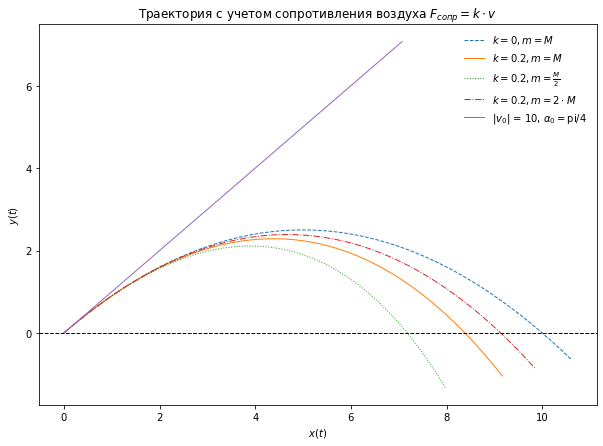

In [24]:
fig, ax = plt.subplots(1, 1, figsize =(10, 7))

ax.set_title(r"Траектория с учетом сопротивления воздуха $F_{сопр} = k\cdot v$")
ax.set_xlabel(r"$x(t)$")
ax.set_ylabel(r"$y(t)$")

ax.plot(*trajectory(x.rhs, y.rhs, {a0: A, v0: V, g: G, k0: 0, m: M}, timeline), ls='dashed', lw=1, label=r'$k = 0, m = M$')
ax.plot(*trajectory(x.rhs, y.rhs, {a0: A, v0: V, g: G, k0: 0.2, m: M}, timeline), ls='solid', lw=1, label=r'$k = 0.2, m = M$')
ax.plot(*trajectory(x.rhs, y.rhs, {a0: A, v0: V, g: G, k0: 0.2, m: M/2}, timeline), ls='dotted', lw=1, label=r'$k = 0.2, m = \frac{M}{2}$')
ax.plot(*trajectory(x.rhs, y.rhs, {a0: A, v0: V, g: G, k0: 0.2, m: M*2}, timeline), ls='dashdot', lw=1, label=r'$k = 0.2, m = 2\cdot M$')
ax.plot((0, float(N(V * sin(A)))), (0, float(N(V * cos(A)))), lw=1, label=f"$|v_0|$ = {V}, " + r"$\alpha_0 =$" + f"{A}")

ax.axhline(0, color='black', ls='dashed', lw=1)
ax.legend(loc='best', frameon=False)
plt.show()

Больше масса - сопротивление меньше, летит дальше (в данной модели)

## <a id='toc4_'></a>[Дальность](#toc0_)

С сопротивлением воздуха аналитического решения, то есть выраженного в элементарных функциях, данная задача не имеет, т.к. аналитически не выражается время горизонтального полета из уравнения $y(t) = 0$, из которого можно было бы получить расстояние и найти максимум по углу. Но что мешает хотя бы попробовать... 

In [25]:
x

Eq(x(t), Piecewise((m*v_0*cos(\alpha_0)/k0 - m*v_0*exp(-k0*t/m)*cos(\alpha_0)/k0, (k0 > 0) | (k0 < 0)), (t*v_0*cos(\alpha_0), True)))

In [26]:
y

Eq(y(t), Piecewise((-g*m*t/k0 + g*m**2/k0**2 + m*v_0*sin(\alpha_0)/k0 - m*(g*m/k0 + v_0*sin(\alpha_0))*exp(-k0*t/m)/k0, (k0 > 0) | (k0 < 0)), ((-g*m*t**2/2 + m*t*v_0*sin(\alpha_0))/m, True)))

### <a id='toc4_1_'></a>[Без сопротивления воздуха](#toc0_)

Укажем, что время положительное, может это поможет отбросить тривиальные и мнимые решения (?).

In [27]:
T = Symbol('T', positive=True)

Находим решение $y(t) = 0$ относительно $t$ - это **время в полете** до встречи с горизонтом.

Подставляем в $x(t)$ - это **дальность** горизонтального полета, выраженная через те переменные, которые мы используем в модели.

In [28]:
tk0 = solve(y.rhs.subs(k0, 0).subs(t, T), T)[0]

sk0 = x.rhs.subs(k0, 0).subs(t, tk0)

P(Eq(Symbol(r'T_{полета}'), tk0), 
  Eq(Symbol(r'S_{полета}'), sk0))

[[Eq(T_{полета}, 2*v_0*sin(\alpha_0)/g)], [Eq(S_{полета}, 2*v_0**2*sin(\alpha_0)*cos(\alpha_0)/g)]]

Угол максимальной дальности горизонтального полета.
- ноль производной от дальности горизонтального полета по начальному углу
- ожидаемо $\pi/4$

In [29]:
ak0diff = sk0.diff(a0)
ak0diff

-2*v_0**2*sin(\alpha_0)**2/g + 2*v_0**2*cos(\alpha_0)**2/g

In [30]:
P(solve(ak0diff)[0])

[[Eq(\alpha_0, pi/4)]]

Тут все верно

### <a id='toc4_2_'></a>[С сопротивлением воздуха](#toc0_)

Считает около 4 минут и выдает вот такое.

Решение выражается через [W-функцию Ламберта](https://ru.wikipedia.org/wiki/W-%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%9B%D0%B0%D0%BC%D0%B1%D0%B5%D1%80%D1%82%D0%B0), которая определяется как обратная функция к $f(w)=we^{w}$ для комплексных $w$, и которая применятеся при решении трансцендентных уравнений.

In [31]:
solveT = solve(y.rhs.subs(k0, k).subs(t, T), T)

Какой физический смысл мнимой части и сопряженного решения понять могут не только лишь все, но действительная часть одного из решений дает дальность полета с учетом сопротивления воздуха. При этом значение W-функции, очевидно, вычисляется приближенно.

- `chop=True` отбрасывает все незначащее, в данном случае величина мнимой части намного меньше погрешности по-умолчанию в `sympy` 

In [32]:
P(N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[0]).subs({a0: A, v0: V, g: G, k: 0.2, m: M}), chop=True),
  N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[0]).subs({a0: A, v0: V, g: G, k: 0.2, m: M/2}), chop=True),
  N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[0]).subs({a0: A, v0: V, g: G, k: 0.2, m: M*2}), chop=True))

[[8.38331148268787], [7.17528805949574], [9.12932244294679]]

- что это за "решения" тоже понять могут не только лишь все, мало кто может это сделать

In [33]:
P(N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[1]).subs({a0: A, v0: V, g: G, k: 0.2, m: M}), chop=True),
  N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[1]).subs({a0: A, v0: V, g: G, k: 0.2, m: M/2}), chop=True),
  N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[1]).subs({a0: A, v0: V, g: G, k: 0.2, m: M*2}), chop=True))

[[26.7914853882183], [13.9407056054608], [52.3549599380762]]

Википедия говорит время полета с сопротивлением Стокса - это:

$${\displaystyle t={\frac {1}{\mu }}\left(1+{\frac {\mu }{g}}v_{y0}+W\left(-\left(1+{\frac {\mu }{g}}v_{y0}\right) e^{-\left(1+{\frac {\mu }{g}}v_{y0}\right)}\right)\right)}$$

Т.е. похоже у нас все правильно.

Изобразим зависимость угла максимальной горизонтальной дальности от сопротивления воздуха.

In [34]:
spatium = lambda _k, _agrad: N(x.rhs.subs(k0, k).subs(t, T).subs(T, solveT[0]).subs({a0: _agrad * pi / 180, v0: V, g: G, k: _k, m: M}), chop=True, n=10)

In [36]:
xs = np.linspace(0.001, 3, 20)
ys = np.linspace(30, 60, 20)

X, Y = np.meshgrid(xs, ys)
zs = np.vectorize(spatium)(X, Y)

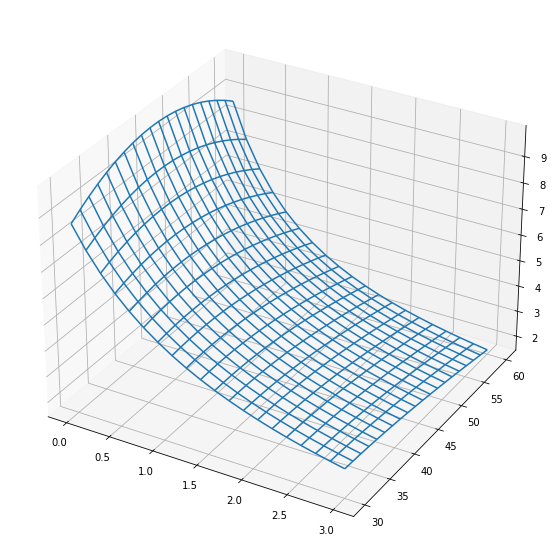

In [37]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, zs)
plt.show()

### <a id='toc4_3_'></a>[Аналитически - не решается](#toc0_)

In [38]:
sk = x.rhs.subs(k0, 0).subs(t, solveT[0])
sk

v_0*(m*LambertW(-sqrt(4*g**2*m**2*exp(2*I*\alpha_0) - 4*I*g*k*m*v_0*exp(3*I*\alpha_0) + 4*I*g*k*m*v_0*exp(I*\alpha_0) - k**2*v_0**2*exp(4*I*\alpha_0) + 2*k**2*v_0**2*exp(2*I*\alpha_0) - k**2*v_0**2)*exp(-I*\alpha_0 - 1 - k*v_0*sin(\alpha_0)/(g*m))/(2*g*m))/k + m/k - I*v_0*exp(I*\alpha_0)/(2*g) + I*v_0*exp(-I*\alpha_0)/(2*g))*cos(\alpha_0)

In [39]:
akdiff = sk.diff(a0)
akdiff

v_0*(-2*g*m**2*(-(-I - k*v_0*cos(\alpha_0)/(g*m))*sqrt(4*g**2*m**2*exp(2*I*\alpha_0) - 4*I*g*k*m*v_0*exp(3*I*\alpha_0) + 4*I*g*k*m*v_0*exp(I*\alpha_0) - k**2*v_0**2*exp(4*I*\alpha_0) + 2*k**2*v_0**2*exp(2*I*\alpha_0) - k**2*v_0**2)*exp(-I*\alpha_0 - 1 - k*v_0*sin(\alpha_0)/(g*m))/(2*g*m) - (4*I*g**2*m**2*exp(2*I*\alpha_0) + 6*g*k*m*v_0*exp(3*I*\alpha_0) - 2*g*k*m*v_0*exp(I*\alpha_0) - 2*I*k**2*v_0**2*exp(4*I*\alpha_0) + 2*I*k**2*v_0**2*exp(2*I*\alpha_0))*exp(-I*\alpha_0 - 1 - k*v_0*sin(\alpha_0)/(g*m))/(2*g*m*sqrt(4*g**2*m**2*exp(2*I*\alpha_0) - 4*I*g*k*m*v_0*exp(3*I*\alpha_0) + 4*I*g*k*m*v_0*exp(I*\alpha_0) - k**2*v_0**2*exp(4*I*\alpha_0) + 2*k**2*v_0**2*exp(2*I*\alpha_0) - k**2*v_0**2)))*exp(I*\alpha_0 + 1 + k*v_0*sin(\alpha_0)/(g*m))*LambertW(-sqrt(4*g**2*m**2*exp(2*I*\alpha_0) - 4*I*g*k*m*v_0*exp(3*I*\alpha_0) + 4*I*g*k*m*v_0*exp(I*\alpha_0) - k**2*v_0**2*exp(4*I*\alpha_0) + 2*k**2*v_0**2*exp(2*I*\alpha_0) - k**2*v_0**2)*exp(-I*\alpha_0 - 1 - k*v_0*sin(\alpha_0)/(g*m))/(2*g*m))/(k*

Выразить $\alpha_0$ не получится, т.к. это - параметр $W$...